In [1]:
import numpy as np
import random
import numpy 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [242]:
lines=open("paraboloid_train.txt","r",encoding="utf-8").readlines()
train_X=[]
train_Y=[]
for l in lines:
    data=l.strip().split(" ")
    tmp=[]
    tmp.append(float(data[0]))
    tmp.append(float(data[1]))
    train_X.append(tmp)
    train_Y.append(float(data[2]))
train_X=np.array(train_X)
train_Y=np.array([train_Y]).T  

In [246]:
def readTestData(path):
    lines=open(path,"r",encoding="utf-8").readlines()
    X=[]
    Y=[]
    for l in lines:
        data=l.strip().split(" ")
        tmp=[]
        tmp.append(float(data[0]))
        tmp.append(float(data[1]))
        X.append(tmp)
        Y.append(float(data[2]))
    return np.array(X),np.array([Y]).T    

In [247]:
test1="paraboloid_test1.txt"
test2="paraboloid_test2.txt"
test3="paraboloid_test3.txt"
test1_X,test1_Y=readTestData(test1)
test2_X,test2_Y=readTestData(test2)
test3_X,test3_Y=readTestData(test3)

In [248]:
def plot3D(x,y,z):
    fig=plt.figure()
    ax=Axes3D(fig)
    ax.scatter(x,y,z,c='b')

(1000, 1)

# 1.基础部分

## 1.1双隐藏层的网络

In [12]:
random.seed(0)

# 生成a和b的随机数
def rand(a,b):
    return (b-a)*random.random()+a

# 创建一个指定大小的矩阵
def make_matrix(m,n,fill=0.0):
    mat=[]
    for i in range(m):
        mat.append([fill]*n)
    mat=np.array(mat)    
    return mat 

# 定义relu函数
def relu(x):
    return np.maximum(np.zeros(x.shape),x)  

In [29]:
class BPNeuralNetwork:
    def __init__(self,ni,nh1,nh2,no):
        # 初始化变量
        self.input_n=0
        self.hidden1_n=0
        self.hidden2_n=0
        self.output_n=0
        self.input_cells=[]
        self.hidden1_in=[]
        self.hidden1_cells=[]
        self.hidden2_in=[]
        self.hidden2_cells=[]
        self.output_cells=[]
        self.input_weights=[]
        self.hidden_weights=[]
        self.output_weights=[]

        # 三个列表维护输入层、隐藏层、输出层神经元
        self.input_n=ni # 输入层，由于偏置项会另外单独加，所以维度不需要加一
        self.hidden1_n=nh1
        self.hidden2_n=nh2
        self.output_n=no    
        # 初始化神经元
        self.input_cells=[1.0]*self.input_n
        self.hidden1_cells=[1.0]*self.hidden1_n
        self.hidden2_cells=[1.0]*self.hidden2_n
        self.output_cells=[1.0]*self.output_n

        # 初始化连接边的边权
        self.input_weights=make_matrix(self.input_n,self.hidden1_n) #输入层->隐藏层1
        self.hidden_weights=make_matrix(self.hidden1_n,self.hidden2_n) # 隐藏层1->隐藏层2
        self.output_weights=make_matrix(self.hidden2_n,self.output_n) # 隐藏层2->输出层

        # 随机初始化边权,这样可以使对称失效
        # 输入层->隐藏层1
        for i in range(self.input_n):
            for h in range(self.hidden1_n):
                self.input_weights[i][h]=rand(-1,1)
        # 隐藏层1->隐藏层2
        for i in range(self.hidden1_n):
            for h in range(self.hidden2_n):
                self.hidden_weights[i][h]=rand(-1,1)
        # 隐藏层2->输出层        
        for i in range(self.hidden2_n):
            for h in range(self.output_n):
                self.output_weights[i][h]=rand(-1,1)      

        #随机初始化bias
        self.h1_b=np.array([np.random.random(self.hidden1_n)])
        self.h2_b=np.array([np.random.random(self.hidden2_n)])
        self.o_b=np.array([np.random.random(self.output_n)])

    # 输出预测值
    def predict(self,inputs):
        self.input_cells=np.array(inputs)
        # 计算隐藏层的输出，每个节点最终的输出值就是权值*节点值的加权和
        self.hidden1_in=self.input_cells.dot(self.input_weights)+self.h1_b
        self.hidden1_cells=relu(self.hidden1_in)
        self.hidden2_in=self.hidden1_cells.dot(self.hidden_weights)+self.h2_b
        self.hidden2_cells=relu(self.hidden2_in)
        self.output_cells=self.hidden2_cells.dot(self.output_weights)+self.o_b
        return self.output_cells

    # 反向传播算法
    # 更新公式为w=w+lr*偏导
    def BP(self,input,label,lr,lam):
        output_predict=self.predict(input)
        N=len(label)
        label=np.array(label)
        delta_b3=(output_predict-label).sum()/(2*N)
        delta_w3=self.hidden2_cells.T.dot(output_predict-label)/(2*N)+2*lam*self.output_weights
        deri_hidden2_out=(output_predict-label)*self.output_weights.T/(2*N)
        deri_hidden2_in=deri_hidden2_out
        delta_b2=deri_hidden2_in.sum(axis=0)/(2*N) # 1*hidden2_size
        delta_w2=self.hidden1_cells.T.dot(deri_hidden2_in)+2*lam*self.hidden_weights # hidden1_size*hidden2_size
        deri_hidden1_out=deri_hidden2_out.dot(self.hidden_weights.T)
        deri_hidden1_in=deri_hidden1_out
        delta_b1=deri_hidden1_in.sum(axis=0)/(2*N)
        delta_w1=input.T.dot(deri_hidden1_in)+2*lam*self.input_weights
        loss=np.sum((output_predict-label)**2)/N+lam*(np.sum(self.input_weights**2)+np.sum(self.hidden_weights**2)+np.sum(self.output_weights**2))
        
        self.o_b-=lr*delta_b3
        self.output_weights-=lr*delta_w3
        self.h2_b-=lr*delta_b2
        self.hidden_weights-=lr*delta_w2
        self.h1_b-=lr*delta_b1
        self.input_weights-=lr*delta_w1

        return loss

    def train(self,cases,labels,epochs,lam,lr):
        es=[]
        # labels=np.array([labels]).T
        cases=np.array(cases)
        for e in range(epochs):
            # 在BP里边进行了预测
            error=self.BP(cases,labels,lr,lam)
            es.append(error)
        return es  


    def test(self,input,label):
        predict=self.predict(input)
        print(f"predict.shape={predict.shape},label.shape={label.shape}")
        mse=np.sum((label-predict)**2)/len(label)
        
        return predict,mse

# 初始化一个双层神经网络，第一个隐藏层有3个神经元，第2个隐藏层有4个神经元
epochs=1000
nn=BPNeuralNetwork(2,20,20,1)
result=nn.train(train_X,train_Y,epochs,5e-3,0.01)

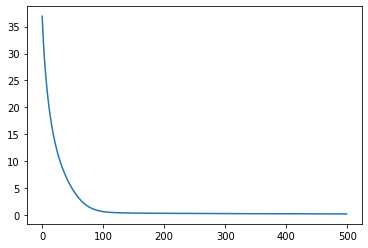

In [304]:
plt.plot(range(epochs),result)

In [295]:
predict_test1,mse1=nn.test(test1_X,test1_Y)
predict_test2,mse2=nn.test(test2_X,test2_Y)
predict_test3,mse3=nn.test(test3_X,test3_Y)
print(mse1,mse2,mse3)

predict.shape=(1000, 1),label.shape=(1000, 1)
predict.shape=(1000, 1),label.shape=(1000, 1)
predict.shape=(1000, 1),label.shape=(1000, 1)
7.402723560213434 0.1679331014138693 0.5795286322411995


## 1.2 单隐藏层网络

In [309]:
# 单层神经网络
class BPNeuralNetwork_single:
    def __init__(self,ni,nh1,no):
        # 初始化变量
        self.input_n=0
        self.hidden1_n=0
        self.output_n=0
        self.input_cells=[]
        self.hidden1_in=[]
        self.hidden1_cells=[]
        self.output_cells=[]
        self.input_weights=[]
        self.output_weights=[]

        # 三个列表维护输入层、隐藏层、输出层神经元
        self.input_n=ni # 输入层，由于偏置项会另外单独加，所以维度不需要加一
        self.hidden1_n=nh1
        self.output_n=no    
        # 初始化神经元
        self.input_cells=[1.0]*self.input_n
        self.hidden1_cells=[1.0]*self.hidden1_n
        self.output_cells=[1.0]*self.output_n

        # 初始化连接边的边权
        self.input_weights=make_matrix(self.input_n,self.hidden1_n) #输入层->隐藏层1
        self.output_weights=make_matrix(self.hidden1_n,self.output_n) # 隐藏层1->输出层

        # 随机初始化边权,这样可以使对称失效
        # 输入层->隐藏层1
        for i in range(self.input_n):
            for h in range(self.hidden1_n):
                self.input_weights[i][h]=rand(-1,1)
        # 隐藏层1->输出层        
        for i in range(self.hidden1_n):
            for h in range(self.output_n):
                self.output_weights[i][h]=rand(-1,1)      

        #随机初始化bias
        self.h1_b=np.array([np.random.random(self.hidden1_n)])
        self.o_b=np.array([np.random.random(self.output_n)])

    # 输出预测值
    def predict(self,inputs):
        self.input_cells=np.array(inputs)
        # 计算隐藏层的输出，每个节点最终的输出值就是权值*节点值的加权和
        self.hidden1_in=self.input_cells.dot(self.input_weights)+self.h1_b
        self.hidden1_cells=relu(self.hidden1_in)
        self.output_cells=self.hidden1_cells.dot(self.output_weights)+self.o_b
        return self.output_cells

    # 反向传播算法
    # 更新公式为w=w+lr*偏导
    def BP(self,input,label,lr,lam):
        output_predict=self.predict(input)
        N=len(label)
        label=np.array(label)
        delta_b2=(output_predict-label).sum()/(2*N)
        delta_w2=self.hidden1_cells.T.dot(output_predict-label)/(2*N)+2*lam*self.output_weights
        deri_hidden1_out=(output_predict-label)*self.output_weights.T/(2*N)
        deri_hidden1_in=deri_hidden1_out
        delta_b1=deri_hidden1_in.sum(axis=0)/(2*N) # 1*hidden2_size
        delta_w1=input.T.dot(deri_hidden1_in)+2*lam*self.input_weights
        loss=np.sum((output_predict-label)**2)/N+lam*(np.sum(self.input_weights**2)+np.sum(self.output_weights**2))
        
        self.o_b-=lr*delta_b2
        self.output_weights-=lr*delta_w2
        self.h1_b-=lr*delta_b1
        self.input_weights-=lr*delta_w1

        return loss

    def train(self,cases,labels,epochs,lam,lr):
        es=[]
        # labels=np.array([labels]).T
        cases=np.array(cases)
        for e in range(epochs):
            # 在BP里边进行了预测
            error=self.BP(cases,labels,lr,lam)
            es.append(error)
        return es  


    def test(self,input,label):
        predict=self.predict(input)
        print(f"predict.shape={predict.shape},label.shape={label.shape}")
        mse=np.sum((label-predict)**2)/len(label)
        
        return predict,mse

# 初始化一个单层神经网络，隐藏层有3个神经元
epochs=200
nn_single=BPNeuralNetwork_single(2,5,1)
result=nn_single.train(train_X,train_Y,epochs,5e-3,0.01)

In [311]:
predict_test1,mse1=nn_single.test(test1_X,test1_Y)
predict_test2,mse2=nn_single.test(test2_X,test2_Y)
predict_test3,mse3=nn_single.test(test3_X,test3_Y)
print(mse1,mse2,mse3)

predict.shape=(1000, 1),label.shape=(1000, 1)
predict.shape=(1000, 1),label.shape=(1000, 1)
predict.shape=(1000, 1),label.shape=(1000, 1)
13.700357304122893 9.568963450404917 23.026337407854008


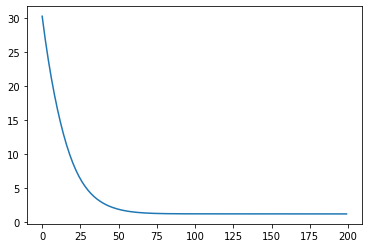

In [310]:
plt.plot(range(epochs),result[:epochs])

## 1.3生成一组非抛物面的几何形状

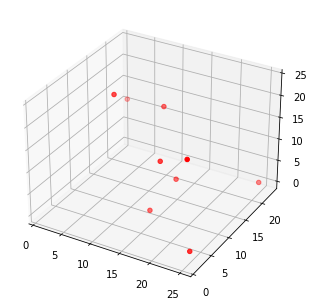

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from random import choice

data=np.random.randint(0,27,(9,3))
x=data[:,0]
y=data[:,1]
z=data[:,2]

fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(x,y,z,c='r')

In [22]:
# 随机生成npoints个半径为r的球面上的点并可视化
npoints=1000
train_size=npoints*0.9
x,y,z=[],[],[]
r=2
flag=[-1,1]
for i in range(npoints):
    x0=rand(-1*r,r)
    upper_bounds=r**2-x0**2
    y0=rand(-math.sqrt(upper_bounds),math.sqrt(upper_bounds))
    z0=choice(tmp)*math.sqrt(r**2-y0**2-x0**2)
    x.append(x0)
    y.append(y0)
    z.append(z0)

In [15]:
print(x[:5],y[:5],z[:5])

[1.03181761176121, 1.8618595454476687, 1.8711999796806857, 0.018747423269561025, 0.4734759867013265] [-0.2721673593097129, -0.020556722081585987, -0.20046939273875852, -0.872610283282067, -0.9696057376712611] [1.6915310652145206, 0.7301071525486249, -0.6770691682671384, -1.7994998826427142, -1.683949287684215]


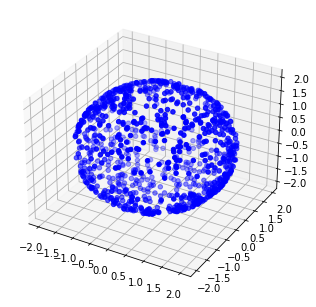

In [23]:
# 可视化
fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(x,y,z,c='b')

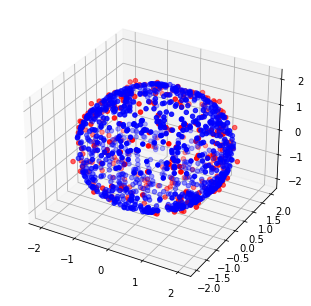

In [27]:
# 给30%的点添加噪声后可视化,其中红色的是带噪音的点
x_nosi=[]
y_nosi=[]
z_nosi=[]
slice=random.sample(range(npoints),int(0.3*npoints))
for i in slice:
    x_nosi.append(x[i]+0.1*choice(flag))
    y_nosi.append(y[i]+0.1*choice(flag))
    z_nosi.append(z[i]+0.1*choice(flag))
fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(x,y,z,c='b')
ax.scatter(x_nosi,y_nosi,z_nosi,c='r')

In [34]:
cnt=0
sphere_X=[]
sphere_Y=[]
for i in range(npoints):
    tmp=[]
    if i in slice:
        tmp.append(x_nosi[cnt])
        tmp.append(y_nosi[cnt])
        sphere_Y.append(z_nosi[cnt])
        cnt+=1
    else:
        tmp.append(x[i])
        tmp.append(y[i])
        sphere_Y.append(z[i])
    sphere_X.append(tmp)
sphere_X=np.array(sphere_X)    
sphere_Y=np.array([sphere_Y]).T         

In [103]:
nn_sphere=BPNeuralNetwork(2,10,20,1)
train_sphere_X,train_sphere_Y=sphere_X[:int(train_size)],sphere_Y[:int(train_size)]
test_sphere_X,test_sphere_Y=sphere_X[int(train_size):],sphere_Y[int(train_size):]


In [53]:
sphere_X[:5,0]

array([ 0.43168332, -1.58828112,  0.88947931,  0.2221804 ,  1.11834786])

In [104]:
epochs=200
es=nn_sphere.train(train_sphere_X,train_sphere_Y,epochs,5e-3,0.01)

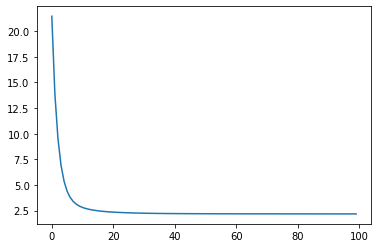

In [106]:
conv=100
plt.plot(range(conv),es[:conv])

In [94]:
predict,mse=nn_sphere.test(test_sphere_X,test_sphere_Y)

predict.shape=(100, 1),label.shape=(100, 1)


In [95]:
mse

1.7752496335050898

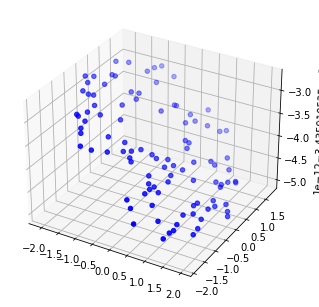

In [58]:
plot3D(sphere_X[int(train_size):,0],sphere_X[int(train_size):,1],predict)

# 2.进阶部分

## 2.1 使用mindspore实现相同的网络